# Building a chatbot on UCF FAQ data by fine-tuning GPT2 model
### Installing accelerate and Parameter efficient fine-tuning library

In [1]:
!pip install --upgrade accelerate
!pip install peft
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.27.2
    Uninstalling accelerate-0.27.2:
      Successfully uninstalled accelerate-0.27.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


### Importing necessary packages

In [29]:
# we upgraded `accelerate` just because to import Trainer API
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, PeftModel, PeftConfig, LoraConfig, TaskType
from glob import glob
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

### Initializing global constant variables

In [3]:
MODEL_NAME = "gpt2"
DATASET_NAME = "/kaggle/input/faq-ucf/faqsUcfDataset.csv"
SPLIT = 0.2
MAX_LENGTH = 128
EPOCHS = 150

### Defining a DataPreprocessor class that will:
#### 1. Load dataset
#### 2. Preprocess the dataset
#### 3. Initialize an AutoTokenizer and use it to tokenize the dataset
#### 4. Include labels to the dataset

In [4]:
class DataPreprocessor:
    def __init__(self, model_name, max_length):
        # Initialize the DataPreprocessor with the specified model name and max_length
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.pad_token = "<pad>"
    
    def load_dataset(self, dataset_name, split):
        # Load the dataset using the specified split
        try:
            print(f"Loading {dataset_name} dataset...")
            df = pd.read_csv(dataset_name)
            train_ds, validation_ds = train_test_split(df, test_size=SPLIT)
            train_ds = train_ds.reset_index()
            validation_ds = validation_ds.reset_index()
            print(f"Loaded {dataset_name} dataset.")
            return train_ds, validation_ds
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None, None
    
    def preprocess(self, dataset):
        print("Preprocessing dataset...")
        try:
            # Preprocess the dataset by combining question and answer text
            dataset["text"] = dataset["Q"] + " " + dataset["A"]
            # Drop original columns
            preprocessed_dataset = dataset.drop(['Q', 'A'], axis=1)
            print("Dataset preprocessing completed.")
            return preprocessed_dataset
        except Exception as e:
            print(f"Error preprocessing dataset: {e}")
            return None
    
    def tokenize(self, dataset):
        # Tokenize the dataset
        print("Tokenizing dataset...")
        def tokenize_function(examples):
            return self.tokenizer(examples["text"], max_length=self.max_length, truncation=True, padding="max_length")
        
        try:
            tokenized_dataset = dataset.apply(tokenize_function, axis=1)
            print("Dataset tokenization completed.")
            return tokenized_dataset
        except Exception as e:
            print(f"Error tokenizing dataset: {e}")
            return None
    
    def add_labels(self, dataset):
        # Add labels to the dataset
        print("Adding labels to dataset...")
        def copy_input_ids(example):
            example["labels"] = example["input_ids"].copy()
            return example
        
        try:
            labeled_dataset = dataset.apply(copy_input_ids)
            print("Labels added to dataset.")
            return labeled_dataset
        except Exception as e:
            print(f"Error adding labels to dataset: {e}")
            return None
    
    def preprocess_pipeline(self, dataset_name, split):
        # Execute the preprocessing pipeline
        train_ds, validation_ds = self.load_dataset(dataset_name, split)
        if train_ds is None or validation_ds is None:
            # Dataset loading failed, return None
            print("Preprocessing pipeline aborted due to dataset loading error.")
            return None, None
        
        train_ds = self.preprocess(train_ds)
        validation_ds = self.preprocess(validation_ds)
        if train_ds is None or validation_ds is None:
            # Dataset preprocessing failed, return None
            print("Preprocessing pipeline aborted due to dataset preprocessing error.")
            return None, None
        
        train_ds = self.tokenize(train_ds)
        validation_ds = self.tokenize(validation_ds)
        if train_ds is None or validation_ds is None:
            # Dataset tokenization failed, return None
            print("Preprocessing pipeline aborted due to dataset tokenization error.")
            return None, None
        
        train_ds = self.add_labels(train_ds)
        validation_ds = self.add_labels(validation_ds)
        if train_ds is None or validation_ds is None:
            # Adding labels failed, return None
            print("Preprocessing pipeline aborted due to label addition error.")
            return None, None
        
        return train_ds, validation_ds

### Initializing a DataPreprocessor object and using it to load and preprocess UCF_FAQ dataset

In [5]:
# DataPreprocessor instance
preprocessor = DataPreprocessor(MODEL_NAME, MAX_LENGTH)
# Obtaining train, val datasets and tokenizing them
tokenized_train_ds, tokenized_validation_ds = preprocessor.preprocess_pipeline(DATASET_NAME, SPLIT)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading /kaggle/input/faq-ucf/faqsUcfDataset.csv dataset...
Loaded /kaggle/input/faq-ucf/faqsUcfDataset.csv dataset.
Preprocessing dataset...
Dataset preprocessing completed.
Preprocessing dataset...
Dataset preprocessing completed.
Tokenizing dataset...
Dataset tokenization completed.
Tokenizing dataset...
Dataset tokenization completed.
Adding labels to dataset...
Labels added to dataset.
Adding labels to dataset...
Labels added to dataset.


### Initializing pretrained GPT2 model

In [6]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Initializing Low Rank Adaptation configurations
### Advantages of using LoRA :
### - Trainable parameter reduction -> Less data is required for fine-tuning
### - Faster training
### - Uses less memory
### - PEFT library makes it look so easy!

In [7]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # task_type, token classification (TaskType.CAUSAL_LM)
    inference_mode=False,
    r=8,                           # r, the dimension of the low-rank matrices
    lora_alpha=16,                 # lora_alpha, scaling factor for the weight matrices
    lora_dropout=0.3,              # lora_dropout, dropout probability of the LoRA layers
    fan_in_fan_out=True,
    bias="lora_only"               # bias, set to only lora layers to train
    
)

### Converting our pretrained GPT2 model to lora_model

In [8]:
# Converting our model to lora
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 322,560 || all params: 124,734,720 || trainable%: 0.2585968044823446


### Initializing training arguments for fine-tuning job

In [9]:
training_args = TrainingArguments(
    "gpt2-on-ucf-faq",
    # Number of epochs to train
    num_train_epochs=EPOCHS,
    # Training batch size
    per_device_train_batch_size=32,
    # Validation batch size
    per_device_eval_batch_size=32,
    # Number of parallel workers
    dataloader_num_workers=2,

    #Evaluating our model after each epoch
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy="epoch",

    learning_rate=1e-3,
    weight_decay=0.01,
    save_total_limit=10,
    report_to='none',

    # Enabling the model to rollback to best checkpoint
    load_best_model_at_end=True,
)

### Defining compute_metric function to calculate perplexity of our model after every epoch

In [10]:
def compute_metrics(pred):
    logits = torch.from_numpy(pred.predictions)
    labels = torch.from_numpy(pred.label_ids)
    loss = F.cross_entropy(logits.view(-1, preprocessor.tokenizer.vocab_size), labels.view(-1))
    return {'perplexity': torch.exp(loss), 'calculated_loss': loss}

### Building a trainer object on our model and training_arguments

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_validation_ds,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training/Fine-tuning our lora-gpt2 model on UCF_FAQ dataset

In [12]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
train_output = trainer.train()
print(train_output)

Epoch,Training Loss,Validation Loss,Perplexity,Calculated Loss,Runtime,Samples Per Second,Steps Per Second
1,3.746300,2.213741,391.747040,5.970616,3.227000,23.242000,0.930000
2,2.243300,2.088424,574.722107,6.353887,3.242000,23.134000,0.925000
3,2.082400,2.027468,593.936340,6.386772,3.198400,23.449000,0.938000
4,2.028700,1.994655,585.423157,6.372335,3.167300,23.680000,0.947000
5,2.024800,1.974176,567.981934,6.342090,3.193500,23.485000,0.939000
6,1.955600,1.956559,577.791138,6.359212,3.206500,23.390000,0.936000
7,1.913500,1.941197,604.543030,6.404473,3.257900,23.021000,0.921000
8,1.907800,1.927069,619.277832,6.428554,3.184100,23.554000,0.942000
9,1.881200,1.913615,654.767151,6.484280,3.285300,22.829000,0.913000
10,1.841100,1.904424,670.694763,6.508314,3.165100,23.696000,0.948000


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1500, training_loss=1.2629718634287517, metrics={'train_runtime': 1361.3955, 'train_samples_per_second': 32.834, 'train_steps_per_second': 1.102, 'total_flos': 2930062668595200.0, 'train_loss': 1.2629718634287517, 'epoch': 150.0})


In [54]:
train_history = pd.DataFrame(trainer.state.log_history)

In [55]:
train_history = train_history.groupby(train_history.index // 2).agg('sum')
train_history.drop(train_history.tail(1).index,inplace=True)

In [56]:
train_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_perplexity,eval_calculated_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.7463,1.040718,0.000993,2.0,20,2.213741,391.747040,5.970616,3.2270,23.242,0.930,0.0,0.0,0.0,0.0,0.0
1,2.2433,0.389207,0.000987,4.0,40,2.088424,574.722107,6.353887,3.2420,23.134,0.925,0.0,0.0,0.0,0.0,0.0
2,2.0824,0.286292,0.000980,6.0,60,2.027468,593.936340,6.386772,3.1984,23.449,0.938,0.0,0.0,0.0,0.0,0.0
3,2.0287,0.296808,0.000973,8.0,80,1.994655,585.423157,6.372335,3.1673,23.680,0.947,0.0,0.0,0.0,0.0,0.0
4,2.0248,0.395737,0.000967,10.0,100,1.974176,567.981934,6.342090,3.1935,23.485,0.939,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.9736,1.099381,0.000027,292.0,2920,1.749517,5386.745605,8.591697,3.3052,22.692,0.908,0.0,0.0,0.0,0.0,0.0
146,0.9567,0.965424,0.000020,294.0,2940,1.749715,5396.088379,8.593430,3.2348,23.185,0.927,0.0,0.0,0.0,0.0,0.0
147,0.9638,1.036886,0.000013,296.0,2960,1.749538,5401.638672,8.594458,3.2534,23.053,0.922,0.0,0.0,0.0,0.0,0.0
148,0.9818,1.141880,0.000007,298.0,2980,1.750151,5413.938477,8.596732,3.2040,23.408,0.936,0.0,0.0,0.0,0.0,0.0


In [57]:
def plot_model_hist(history):
    # Plotting train and validation loss graph
    plt.title('Loss')
    #plt.yticks(np.arange(history['loss'].min(), history['loss'].max(), step=(history['loss'].max() - history['loss'].min() // 10)))
    plt.plot(history['loss'], label='train')
    plt.plot(history['eval_loss'],
    label='test')
    plt.legend()
    plt.savefig('loss_graph.png')
    plt.show()

    # Plotting train and validation F1 score graph
    plt.title('Perplexity score')
    plt.plot(history['eval_perplexity'],
    label='test')
    plt.legend()
    plt.savefig('perplexity.png')
    plt.show()

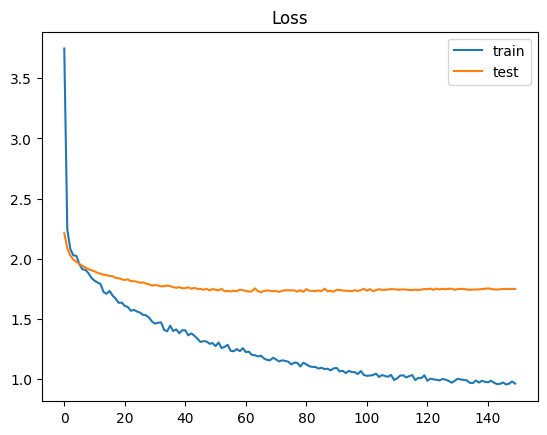

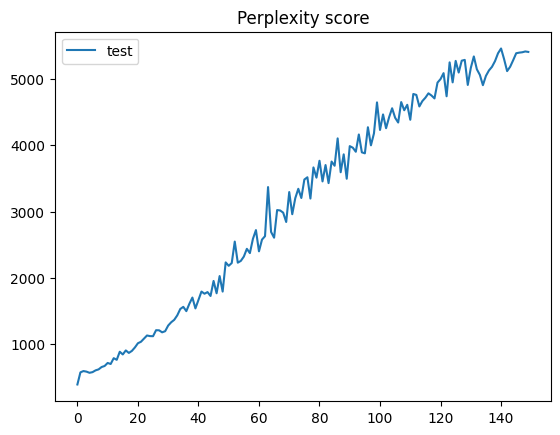

In [58]:
plot_model_hist(train_history)

## Inference

In [13]:
# Create a test prompt
prompt = "How long does it take for an electronic transcript to arrive at UCF?"
# Encode the prompt
encoded_prompt = preprocessor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids
# Transform the encoded representation to the device the model was trained on
encoded_prompt = encoded_prompt.to(trainer.model.device)

# Generating a prediction
output_sequences = trainer.model.generate(
    input_ids=encoded_prompt,
    # Maximum length of predicted sequence
    max_length=MAX_LENGTH,
    min_length=1,
    # Temperature determines how creative/random or strict the model should be
    temperature=.9,
    # Determines the probability sum of tokens that should be kept
    top_p=.95,
    do_sample=True,
    # Predict 3 sequences
    num_return_sequences=3,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
)

generated_sequences = []

# Decoding the predicted sequences
for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
    generated_sequence = generated_sequence.tolist()
    text = preprocessor.tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
    generated_sequences.append(text.strip().split('?')[1])


In [14]:
generated_sequences

[' The transcript arrival time varies by time of year: The most common times are: Saturdays starting 6:00 p.m. on Saturdays starting 5:00 p.m. on Saturdays beginning in the middle of the month and beginning at 6:30 p.m. on Sundays starting 6:30 p.m. on Sundays starting in the middle of the month and beginning at 6:30 p.m. on Mondays beginning in the middle of the month and beginning at 7:00 p.m. on Mondays beginning in the middle of the month and beginning',
 ' Electronic transcripts typically take six to seven business days for transit to the United States. Electronic transcripts usually take approximately 15 to 30 business days for transit to the United States, depending on the type of delivery and the carrier that delivers the transcript.',
 ' Generally speaking, your transcript will arrive at the university within 3-5 business days after your application has been submitted. In addition, the transcript will arrive within 24-28 business days after your first semester on campus.']

## Running our chatbot

In [16]:
while True:
    prompt = input("User > ")
    if prompt:
        if prompt == "bye":
            break
        encoded_prompt = preprocessor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids
        encoded_prompt = encoded_prompt.to(trainer.model.device)

        # prediction
        output_sequences = trainer.model.generate(
            input_ids=encoded_prompt,
            max_length=MAX_LENGTH,
            min_length=1,
            temperature=.9,
            top_p=.95,
            do_sample=True,
            num_return_sequences=1,
            pad_token_id=preprocessor.tokenizer.pad_token_id,
        )

        generated_sequences = []

        # decode prediction
        for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
            generated_sequence = generated_sequence.tolist()
            text = preprocessor.tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
            generated_sequences.append(text.strip().split("?")[1])
        print("Assistant > ", generated_sequences[0])

User >  When should I apply to UCF?


Assistant >   You must apply after your high school graduation from high school. A minimum GPA of 1.00 or more is required for admission into UCF. A minimum of 4.00 from a high school is required. For final acceptance, a minimum of 6 credits from a UCF School of Design are required. NOTE: AUCF does not recognize your final college or university attendance.


User >  Does UCF have on-campus housing?


Assistant >   Students can rent units on campus as housing at UCF housing facilities. Housing is located primarily on campus in Downtown Eastside Eastside and includes the UCF Student Center (1501 E. Roosevelt St.). Once inside, a person can rent one or two units per room, depending on availability. Units are typically reserved for first-year students. A 2-bedroom, three-bathroom, four-orcatery is ideal for large rooms. Units in central dorms are typically reserved for first-year students.


User >  What is the requirements for graduate degree application?


Assistant >   The UCF application requirements are as follows: A high school diploma, transcripts from high school exams, an SAT or CLT from high school exam scores, and an unofficial transcript from an accredited high school. Fills of application fees should be submitted electronically and electronically within 48-hour of application submission. Disciplinary actions should be made by the Academic Council. A university statement of requirements (such as academic integrity, academic fitness, etc.) or a waiver from application application impoundment should be posted online when required. UCF requires both official transcripts and unofficial transcripts available to view. This requirement is


User >  bye
